In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melting-point/sample_submission.csv
/kaggle/input/melting-point/train.csv
/kaggle/input/melting-point/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/melting-point/train.csv')
test_df = pd.read_csv('/kaggle/input/melting-point/test.csv')

In [3]:
train_df.head()

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.isnull().sum()[train_df.isnull().sum() >= 1] #no null values

Series([], dtype: int64)

In [5]:
train_df['SMILES'].nunique() #all unique values

2662

# What RDKit Really Is

RDKit is a chemoinformatics toolkit — basically a software library that helps computers understand and work with molecules.

Think of it like:

> “Python’s magic toolbox for chemistry + ML.”

It lets you load chemical structures, manipulate them, analyze them, and convert molecules into data formats ML models can understand.

## Why It Matters in Machine Learning

In ML for chemistry or drug discovery, you can’t just feed a molecule like C6H6 (benzene) into a model — the computer is like “Uhh... what is this?”

RDKit helps convert molecules into numerical features (fingerprints, descriptors) so ML models can learn patterns like:

- Which compounds make good drugs?

- Which molecules are toxic?

- What chemical properties does a molecule have (solubility, boiling point, etc)?

Basically, it turns chemistry into math for ML.

## Common RDKit ML Outputs

RDKit can generate:

Name|	Meaning
--|--|
Molecular descriptors	|Numerical features (e.g., molecular weight, polarity)
Fingerprints|	Binary vectors representing structure patterns
Smiles parsing|	Reads molecule strings like "CCO"
Molecule visualisation	|Draws chemical structures
Feature engineering	|Adds chemistry features to ML pipelines

## Typical ML Workflow with RDKit

Imagine you're predicting molecule toxicity:

1. Load molecule (SMILES)

2. Use RDKit to extract molecular features

3. Feed features into ML model (RandomForest, XGBoost, etc.)

4. Train & evaluate model

5. Predict properties of new molecules

In [6]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 47.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
from rdkit import Chem

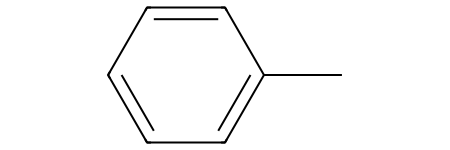

In [8]:
Chem.MolFromSmiles('Cc1ccccc1') #draw molecular structure

# SMILES vs Canonical SMILES

### SMILES

SMILES is just a text way to describe a molecule.

#### Important:
There can be many valid SMILES for the same molecule.

Example: ethanol

In [9]:
#CCO
#OCC
#C(O)C

These all describe the same molecule, just written differently.

So SMILES is like saying:

> “Call me Chisom or Nwankwo Chisom or Chisom N. — I'm still me.”

## Canonical SMILES

Canonical SMILES = a standardized, unique SMILES version for that molecule.

RDKit “canonicalizes” by:

- parsing the molecule

- internally ordering atoms in a consistent way

- returning one unique SMILES string per molecule

So even if input SMILES differ, canonical SMILES forces one representation.

## Why canonicalization matters in ML

Imagine duplicates in your dataset:

SMILES|	Tm
---|---
CCO	|200
OCC	|200

They look different but are the same molecule → leaking duplicates into training and validation.

Canonicalizing helps you:

- Remove duplicates 

- Avoid data leakage 

- Ensure consistency in dataset 

- Improve model reliability 

Basically, it's data cleaning for chemistry.

In [10]:
Chem.MolFromSmiles("CCO") == Chem.MolFromSmiles("OCC")

False

In [11]:
molecule = Chem.MolFromSmiles("COC")
Chem.rdmolfiles.MolToSmiles(molecule) #or Chem.MolToSmiles(molecule, canonical=True)

'COC'

In [12]:
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol) if mol else None

In [13]:
#in lambda function
train_df['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) else None)

0                FC1=C(F)C(F)(F)C1(F)F
1       c1ccc2c(c1)ccc1[nH]c3ccccc3c12
2                   CCn1c(C)nc2ccccc21
3                           CC#CC(=O)O
4                            CCCCC(C)S
                     ...              
2657                            ClCCBr
2658                    N#CC(Cl)(Cl)Cl
2659                Cc1ccc2c(C)cccc2c1
2660             CCC(=O)c1ccc2ccccc2c1
2661                 CN(C)c1ccc(Br)cc1
Name: SMILES, Length: 2662, dtype: object

In [14]:
train_df.insert(2,'canonized_smiles',train_df['SMILES'].apply(canonicalize_smiles))

## What descriptors actually do

Descriptors are numerical summaries of a molecule’s structure and properties — the features your ML model uses to approximate physical behavior.

Since we can’t directly “calculate” melting points from theory, we rely on descriptors to encode everything about a molecule that influences its melting point:

* How big the molecule is (molecular weight)

* How polar it is (LogP, hydrogen bond donors/acceptors)

* How rigid or flexible (rotatable bonds, ring structures)

* How strongly it sticks to other molecules (electrostatics, surface area)

# MODELLING

In [15]:
X = train_df.drop(['id','SMILES','Tm','canonized_smiles'],axis=1)
y = train_df['Tm']

In [16]:
#drop empty features
def drop_features(df):
    for col in df:
        if df[col].sum() < 1:
            df = df.drop(col,axis=1)
    return df

In [17]:
#X = drop_features(X)

In [18]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
#random forest
model = RandomForestRegressor()
model.fit(X_train,y_train)
rf_pred = model.predict(X_val)

mean_absolute_error(y_val,rf_pred)

36.35557909224917

In [20]:
#decisiontree
model = DecisionTreeRegressor()
model.fit(X_train,y_train)
dt_pred = model.predict(X_val)

mean_absolute_error(y_val,dt_pred)

44.643452157598496

In [21]:
#XGB
model = XGBRegressor()
model.fit(X_train,y_train)
xgb_pred = model.predict(X_val)

mean_absolute_error(y_val,xgb_pred)

36.11422207887803

In [22]:
#LGBM
model = LGBMRegressor()
model.fit(X_train,y_train)
lgbm_pred = model.predict(X_val)

#MAE
mean_absolute_error(y_val,lgbm_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 80
[LightGBM] [Info] Start training from score 277.791617


42.85390541581454

Since my XGB model performed the best, I will work with that. Let me try fine tuning the parameters and hopefully improve performance of the model

# MODEL IMPROVEMENT

In [23]:
#XGB
model = XGBRegressor(
    booster = 'gbtree', 
    learning_rate = 0.4, 
    max_depth = None, #increasing can lead to overfitting, deafult = None
    subsample = 1, #range 0-1, deafult = NONE
    tree_method = 'hist',
    max_bin = None
    
)
model.fit(X_train,y_train)
xgb_pred = model.predict(X_val)

mean_absolute_error(y_val,xgb_pred)

35.47446105899775

In [24]:
#model.get_params()

# SUBMISSION

In [25]:
X_test = test_df.drop(['id','SMILES'],axis=1)

In [26]:
predictions = model.predict(X_test)

In [27]:
submission = test_df[['id']]

In [28]:
submission['Tm'] = predictions

/tmp/ipykernel_13/2654297288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Tm'] = predictions


In [29]:
submission = submission.reset_index(drop=True)

In [30]:
submission.to_csv('submission.csv', index=False)

# RESOURCES
1. https://www.rdkit.org/docs/GettingStartedInPython.html
2. https://github.com/rdkit/rdkit
3. https://xgboost.readthedocs.io/en/stable/parameter.html
4. https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors
5. https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/675b14ccf9980725cfdc6658/original/p2mat-a-machine-learning-ml-driven-software-for-property-prediction-of-ma-terial.pdf